# Figures for Ford et al. (2024)

This notebook includes the code required to reproduce the figures in Ford et al. (2024) that do not include feedback analyses (i.e., Figs. 5 and 6), which are in a separate notebook.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cartopy import crs as ccrs
import cartopy.feature as cf
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats import linregress, pearsonr
import xesmf as xe
import glob, os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from climlab.utils.constants import a, g
from climlab.utils.thermo import EIS

Define a global average function and a function that extends the data in longitude for plotting (to remove the line that appears in Cartopy plots):

In [2]:
def global_average(data, lon=True):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    if lon == True: 
        return data_weighted.mean(dim=['lat', 'lon'], skipna=True)
    else: return data_weighted.mean(dim='lat', skipna=True)

def add_cyclic_point(xarray_obj, dim='lon', period=360):
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
    return xr.concat([xarray_obj, first_point], dim=dim)

## Loading in data

### Q-flux data

In [3]:
ctrl_qf = xr.open_dataset('/roselab_rit/rford/OHUTCR-data/pop_frc.b.e11.B1850C5CN.f19_g16.130429.nc')
models_warm = ['BNU-ESM', 'MIROC-ESM', 'NorESM1-ME', 
               'inmcm4', 'MRI-CGCM3', 'CESM1-BGC', 'NorESM1-M', 'bcc-csm1-1-m', 
               'CNRM-CM5-2', 'CCSM4', 'bcc-csm1-1', 'CSIRO-Mk3-6-0']
models_cold = ['ACCESS1-3', 'CNRM-CM5', 'MIROC5']

filenames = []
for model in models_warm:
    filenames.append('hfds_Omon_'+model+'_anom_r1i1p1_1x1_monthly_mean.nc')

filepath = '/roselab_rit/rford/OHUTCR-data/hfds_TCR_diff_1x1/'
temp_hfds_dataset = [xr.open_dataset(filepath + filename, decode_times=False).mean(dim='time') for filename in filenames]
hfds_dataset = xr.concat(temp_hfds_dataset, 'model')

cfilenames = []
for model in models_cold:
    cfilenames.append('hfds_Omon_'+model+'_anom_r1i1p1_1x1_monthly_mean.nc')

ctemp_hfds_dataset = [xr.open_dataset(filepath + filename, decode_times=False).mean(dim='time') for filename in cfilenames]
chfds_dataset = xr.concat(ctemp_hfds_dataset, 'model')

### Response data

| Code name      | Paper name |
| ----------- | ----------- |
| `ctrl` | Control |
| `response` | Ensemble |
| `resp_em` | CM Q-flux |
| `resp_cold` | +$\Delta$SIC |
| `resp_co2` | 2xCO2 only |

In [4]:
ctrl = xr.open_dataset('/roselab_rit/rford/OHUTCR-data/CESM1-CAM5_ctrl.cam.h0.mean.nc').isel(time=0).drop('time')
response = xr.open_dataset('/roselab_rit/rford/OHUTCR-data/warm13-model-tcr-mean-output.nc').drop_sel(model='GFDL-ESM2G')
resp_em = xr.open_dataset('/roselab_rit/rford/OHUTCR-data/cmip5em-tcr-mean-output.nc')
resp_cold = xr.open_dataset('/roselab_rit/rford/OHUTCR-data/cold4-model-tcr-mean-output.nc').drop_sel(model='ACCESS1-0')
resp_co2 = xr.open_dataset('/roselab_rit/rford/OHUTCR-data/CESM1-CAM5_CO2.cam.h0.mean.nc').isel(time=0).drop('time')

## Figure 1: Q-flux maps

Regrid control Q-flux to 1x1 grid:

In [5]:
ctrl_qf_rn = ctrl_qf.mean(dim='time').rename({'xc': 'lon', 'yc': 'lat'})

ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(ctrl_qf_rn, ds_out, 'bilinear')
regr_ctrl_qf = regridder(ctrl_qf_rn.qdp)

Calculate Q-flux multimodel-mean:

In [6]:
qflux_model_mean = hfds_dataset.hfds.mean(dim='model')
qflux_model_sd = hfds_dataset.hfds.std(dim='model')
qflux_model_anom = hfds_dataset.hfds - qflux_model_mean

Calculate global-mean surface temperature (for coloring individual model zonal-mean Q-flux anomalies):

In [7]:
gmst = global_average(response.TREFHT)

Fill in a line of missing data resulting from the regridding. This has no effect on the analysis; it is only for plotting:

In [8]:
regr_ctrl_qf_filled = regr_ctrl_qf.where(regr_ctrl_qf != 0).bfill(dim='x')

The plot:

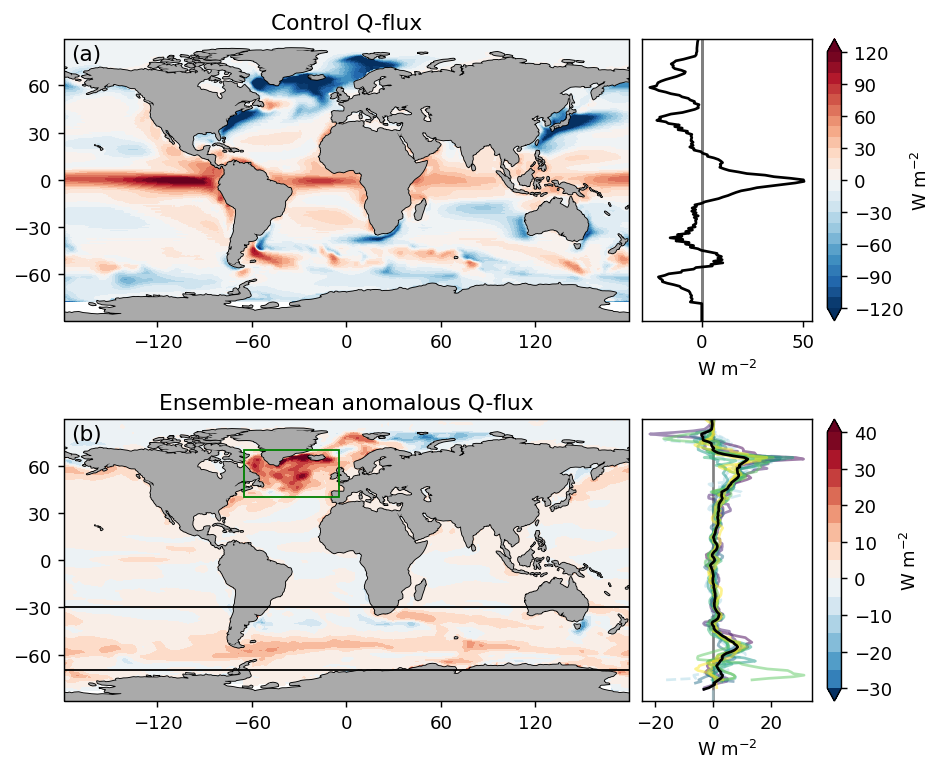

In [9]:
feature = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')

fig = plt.figure(figsize=(8, 6), dpi=130)
ax_mean = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
mean_plot = ax_mean.contourf(qflux_model_mean.lon, qflux_model_mean.lat, qflux_model_mean, cmap='RdBu_r', levels=np.arange(-30, 41, 5), norm=colors.CenteredNorm(), extend='both')
ax_mean.coastlines()
ax_mean.add_feature(feature)
ax_mean.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax_mean.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
plt.colorbar(mean_plot, orientation='vertical', label='W m$^{-2}$', pad=-0.03)
plt.text(-175, 76, '(b)', fontdict={'size': 12})

divider = make_axes_locatable(ax_mean)
ax3 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax3)
ax3.set_yticks([])
    
ax3.plot(0*qflux_model_mean.lat, qflux_model_mean.lat, color='gray', linestyle='-')
for j, m in enumerate(models_cold):
    plt.plot(chfds_dataset.hfds.isel(model=j).mean(dim='lon'), chfds_dataset.lat, color='lightblue', linestyle='--', alpha=0.5)

for j, m in enumerate(models_warm):
    ax3.plot(hfds_dataset.hfds.isel(model=j).mean(dim='lon'), hfds_dataset.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5)
    
    
mz_plot = ax3.plot(hfds_dataset.hfds.mean(dim=['lon', 'model']), qflux_model_mean.lat, 'k')

ax3.set_ylim(-90, 90)
ax3.set_xlabel('W m$^{-2}$')

ax_sd = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
sd_plot = ax_sd.contourf(regr_ctrl_qf_filled.lon, regr_ctrl_qf_filled.lat, regr_ctrl_qf_filled, cmap='RdBu_r', levels=np.arange(-120, 121, 10), norm=colors.CenteredNorm(), extend='both')
ax_sd.coastlines()
ax_sd.add_feature(feature)
ax_sd.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax_sd.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
plt.colorbar(sd_plot, orientation='vertical', label='W m$^{-2}$', pad=-0.03)
plt.text(-175, 76, '(a)', fontdict={'size': 12})

ax_mean.add_patch(mpatches.Rectangle(xy=[-180, -70], width=360, height=40, facecolor='none', edgecolor='k', alpha=1, transform=ccrs.PlateCarree(), zorder=3))
ax_mean.add_patch(mpatches.Rectangle(xy=[-65, 40], width=60, height=30, facecolor='none', edgecolor='g', alpha=1, transform=ccrs.PlateCarree(), zorder=3))

divider2 = make_axes_locatable(ax_sd)
ax5 = divider2.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax5)
ax5.set_yticks([])
    
ax5.plot(0*regr_ctrl_qf.lat, regr_ctrl_qf.lat, color='gray', linestyle='-')
sdz_plot = ax5.plot(regr_ctrl_qf.mean(dim='x'), regr_ctrl_qf.y - 90, 'k')
ax5.set_ylim(-90, 90)
ax5.set_xlabel('W m$^{-2}$')

ax_sd.set_title('Control Q-flux')
ax_mean.set_title('Ensemble-mean anomalous Q-flux')
plt.tight_layout()

## Figure 2: OHU-TCR correlation

Compute TCR:

In [10]:
tcr = global_average(response.TREFHT - ctrl.TREFHT)
em_tcr = global_average(resp_em.TREFHT - ctrl.TREFHT)

Compute region-average Q-fluxes:

In [11]:
soqf = global_average(hfds_dataset.hfds.where((hfds_dataset.lat > -70) & (hfds_dataset.lat < -30)))
naqf = global_average(hfds_dataset.hfds.where((hfds_dataset.lat > 40) & (hfds_dataset.lat < 70) & (hfds_dataset.lon > -65) & (hfds_dataset.lon < -5)))
gmqf = global_average(hfds_dataset.hfds)

em_soqf = global_average(hfds_dataset.mean(dim='model').hfds.where((hfds_dataset.lat > -70) & (hfds_dataset.lat < -30)))
em_naqf = global_average(hfds_dataset.mean(dim='model').hfds.where((hfds_dataset.lat > 40) & (hfds_dataset.lat < 70) & (hfds_dataset.lon > -65) & (hfds_dataset.lon < -5)))
em_gmqf = global_average(hfds_dataset.mean(dim='model').hfds)

The plot:

Text(0.015, 0.98, '(c)')

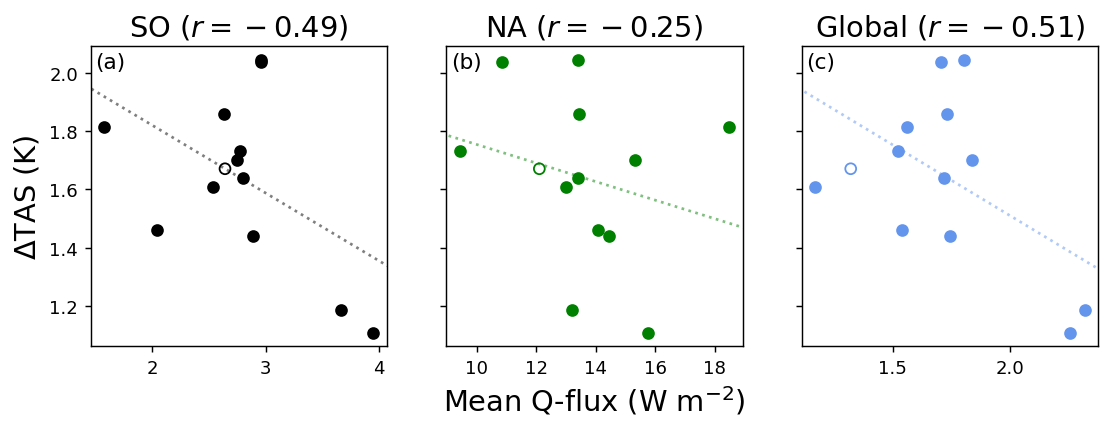

In [12]:
fig = plt.figure(figsize=(10, 3), dpi=130)

x = np.linspace(-100, 100, 20)

z1 = np.polyfit(soqf, tcr, 1)
m1, b1 = z1[0], z1[1]
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(soqf, tcr, color='k')
ax1.scatter(em_soqf, em_tcr, color='k', facecolors='none')
xlim1 = ax1.get_xlim()
ylim1 = ax1.get_ylim()
ax1.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
ax1.set_ylabel('$\Delta$TAS (K)', fontsize=16)
ax1.set_title('SO ($r=%.2f$)' %pearsonr(soqf, tcr)[0], fontsize=16)
ax1.set_ylim(ylim1)
ax1.set_xlim(xlim1)

z2 = np.polyfit(naqf, tcr, 1)
m2, b2 = z2[0], z2[1]
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax2.scatter(naqf, tcr, color='g')
ax2.scatter(em_naqf, em_tcr, color='g', facecolors='none')
xlim2 = ax2.get_xlim()
ylim2 = ax2.get_ylim()
ax2.plot(x, m2*x+b2, color='g', linestyle=':', alpha=0.5)
ax2.tick_params('y', labelleft=False)
ax2.set_xlabel('Mean Q-flux (W m$^{-2}$)', fontsize=16)
ax2.set_title('NA ($r=%.2f$)' %pearsonr(naqf, tcr)[0], fontsize=16)
ax2.set_ylim(ylim2)
ax2.set_xlim(xlim2)

z3 = np.polyfit(gmqf, tcr, 1)
m3, b3 = z3[0], z3[1]
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
ax3.scatter(gmqf, tcr, color='cornflowerblue')
ax3.scatter(em_gmqf, em_tcr, color='cornflowerblue', facecolors='none')
xlim3 = ax3.get_xlim()
ylim3 = ax3.get_ylim()
ax3.plot(x, m3*x+b3, color='cornflowerblue', linestyle=':', alpha=0.5)
ax3.tick_params('y', labelleft=False)
ax3.set_title('Global ($r=%.2f$)' %pearsonr(gmqf, tcr)[0], fontsize=16)
ax3.set_ylim(ylim3)
ax3.set_xlim(xlim3)

ax1.text(.015, .98, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax2.text(.015, .98, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=12)
ax3.text(.015, .98, '(c)', ha='left', va='top', transform=ax3.transAxes, fontsize=12)

## Figure 3: Response

Compute TAS response:

In [13]:
gmst = global_average(response.TREFHT)

tcr_map = response.TREFHT - ctrl.TREFHT
cold_tcr_map = resp_cold.TREFHT - ctrl.TREFHT
em_tcr_map = resp_em.TREFHT - ctrl.TREFHT
ecs_map = resp_co2.TREFHT - ctrl.TREFHT

Compute SIC response:

In [14]:
sic = (response.ICEFRAC - ctrl.ICEFRAC)*100
cold_sic = (resp_cold.ICEFRAC - ctrl.ICEFRAC)*100

em_sic = (resp_em.ICEFRAC - ctrl.ICEFRAC)*100
co2_sic = (resp_co2.ICEFRAC - ctrl.ICEFRAC)*100

Zonal averages:

In [15]:
zm_tcr = tcr_map.mean(dim='lon')
zm_sic = sic.mean(dim='lon')

cold_zm_tcr = cold_tcr_map.mean(dim='lon')
cold_zm_sic = cold_sic.mean(dim='lon')

zm_em_tcr = em_tcr_map.mean(dim='lon')
zm_em_sic = em_sic.mean(dim='lon')

zm_co2_ecs = ecs_map.mean(dim='lon')
zm_co2_sic = co2_sic.mean(dim='lon')

The plot:

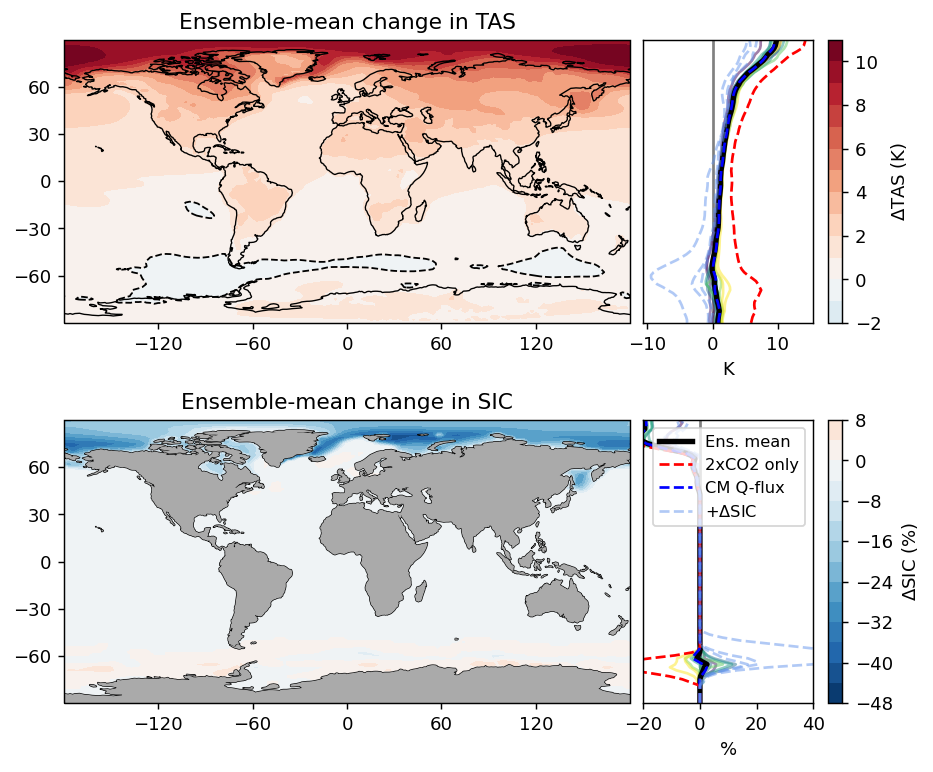

In [16]:
cyclic_tcr = add_cyclic_point(tcr_map)
cyclic_sic = add_cyclic_point(sic)

fig = plt.figure(dpi=130, figsize=(8, 6))

axt = plt.subplot(211, projection=ccrs.PlateCarree())
t_plot = axt.contourf(cyclic_tcr.lon, cyclic_tcr.lat, cyclic_tcr.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=np.arange(-2, 12, 1))
axt.contour(cyclic_tcr.lon, cyclic_tcr.lat, cyclic_tcr.mean(dim='model'), colors='k', levels=[0.0], linestyles='--', linewidths=1)
axt.coastlines(linewidths=0.75)
plt.colorbar(t_plot, orientation='vertical', label='$\Delta$TAS (K)', pad=-0.03)

axs = plt.subplot(212, projection=ccrs.PlateCarree())
s_plot = axs.contourf(cyclic_sic.lon, cyclic_sic.lat, cyclic_sic.mean(dim='model'), cmap='RdBu_r', norm=colors.CenteredNorm(), levels=np.arange(-48, 9, 4))
axs.coastlines(linewidths=0.75)
plt.colorbar(s_plot, orientation='vertical', label='$\Delta$SIC (%)', pad=-0.03)

divider = make_axes_locatable(axt)
ax1 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax1)
ax1.set_yticks([])

ax1.plot(0*zm_tcr.lat, zm_tcr.lat, linestyle='-', color='gray')

for i, m in enumerate(zm_tcr.model):
    ax1.plot(zm_tcr.sel(model=m), zm_tcr.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[i]), linestyle='-', alpha=0.5)

ax1.plot(zm_tcr.mean(dim='model'), zm_tcr.lat, color='k', linewidth=3, label='Ens. mean')
ax1.plot(zm_co2_ecs, ecs_map.lat, color='r', linestyle='--', linewidth=1.5, label='2xCO2 only')
ax1.plot(zm_em_tcr, zm_em_tcr.lat, color='b', linestyle='--', linewidth=1.5, label='CM Q-flux')

for i, m in enumerate(cold_zm_tcr.model):
    if i == 0:
        ax1.plot(cold_zm_tcr.sel(model=m), cold_zm_tcr.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    else:
        ax1.plot(cold_zm_tcr.sel(model=m), cold_zm_tcr.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

divider2 = make_axes_locatable(axs)
ax2 = divider2.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax2)
ax2.set_yticks([])

ax2.plot(0*zm_sic.lat, zm_sic.lat, linestyle='-', color='gray')

for i, m in enumerate(zm_tcr.model):
    ax2.plot(zm_sic.sel(model=m), zm_sic.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[i]), linestyle='-', alpha=0.5)
    
ax2.plot(zm_sic.mean(dim='model'), zm_sic.lat, color='k', linewidth=3, label='Ens. mean')
ax2.plot(zm_co2_sic, ecs_map.lat, color='r', linestyle='--', linewidth=1.5, label='2xCO2 only')
ax2.plot(zm_em_sic, zm_em_sic.lat, color='b', linestyle='--', linewidth=1.5, label='CM Q-flux')

for i, m in enumerate(cold_zm_tcr.model):
    if i == 0:
        ax2.plot(cold_zm_sic.sel(model=m), cold_zm_sic.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif i != 0:
        ax2.plot(cold_zm_sic.sel(model=m), cold_zm_sic.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

ax2.legend(prop = {'size': 9})
ax1.set_ylim(-90, 90)
ax2.set_ylim(-90, 90)
ax2.set_xlim(-20, 40)
ax1.set_xlabel('K')
ax2.set_xlabel('%')

axt.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
axt.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
axs.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
axs.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())

feature = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')
axs.add_feature(feature)

axt.set_title('Ensemble-mean change in TAS')
axs.set_title('Ensemble-mean change in SIC')
plt.tight_layout()

## Figure 4: Hadley circulation shift

Define the mass streamfunction $\psi$:

In [17]:
def psi(ds):
    coslat = np.cos(np.deg2rad(ds.lat))
    psi = 2*np.pi*a*coslat/g * ds.V.mean(dim='lon').cumulative_integrate(coord='lev') / 1E9 * 100
    return psi

Calculate $\psi$ and $\Delta\psi$:

In [18]:
psi_expr = psi(response)
psi_cold = psi(resp_cold)
psi_ctrl = psi(ctrl)
psi_co2 = psi(resp_co2)
psi_em = psi(resp_em)

dpsi = psi_expr - psi_ctrl
dpsi_cold = psi_cold - psi_ctrl
dpsi_co2 = psi_co2 - psi_ctrl
dpsi_em = psi_em - psi_ctrl

Take average over the general area of maximum $\Delta\psi$:

In [19]:
dpsi_mean = global_average(dpsi.where((dpsi.lat > -10) & (dpsi.lat < 5) & (dpsi.lev > 200) & (dpsi.lev < 920), drop=True).mean(dim=['lev']), lon=False)
dpsi_cold_mean = global_average(dpsi_cold.where((dpsi_cold.lat > -10) & (dpsi_cold.lat < 5) & (dpsi_cold.lev > 200) & (dpsi_cold.lev < 920), drop=True).mean(dim=['lev']), lon=False)
dpsi_em_mean = global_average(dpsi_em.where((dpsi_em.lat > -10) & (dpsi_em.lat < 5) & (dpsi_em.lev > 200) & (dpsi_em.lev < 920), drop=True).mean(dim=['lev']), lon=False)
dpsi_co2_mean = global_average(dpsi_co2.where((dpsi_co2.lat > -10) & (dpsi_co2.lat < 5) & (dpsi_co2.lev > 200) & (dpsi_co2.lev < 920), drop=True).mean(dim=['lev']), lon=False)

Calculate hemisphere-mean TAS:

In [20]:
shmst = global_average(response.TREFHT.where(response.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))
shmst_cold = global_average(resp_cold.TREFHT.where(resp_cold.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))
shmst_co2 = global_average(resp_co2.TREFHT.where(resp_co2.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))
shmst_em = global_average(resp_em.TREFHT.where(resp_em.lat < 0)) - global_average(ctrl.TREFHT.where(ctrl.lat < 0))

nhmst = global_average(response.TREFHT.where(response.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))
nhmst_cold = global_average(resp_cold.TREFHT.where(resp_cold.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))
nhmst_co2 = global_average(resp_co2.TREFHT.where(resp_co2.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))
nhmst_em = global_average(resp_em.TREFHT.where(resp_em.lat > 0)) - global_average(ctrl.TREFHT.where(ctrl.lat > 0))

The plot:

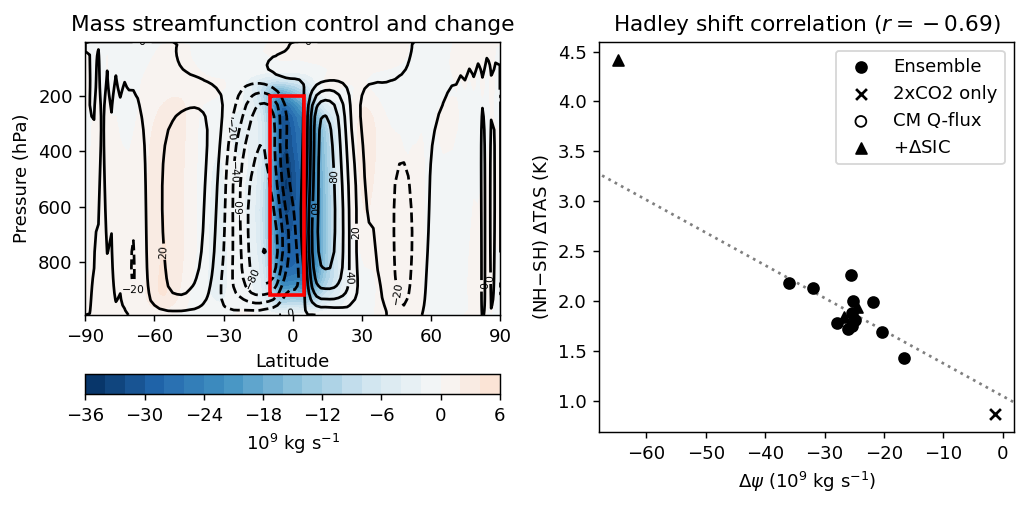

In [21]:
x = np.linspace(-200, 200, 10)
z = np.polyfit(dpsi_mean, (nhmst - shmst), 1)

m, b = z[0], z[1]

fig = plt.figure(figsize=(8, 4), dpi=130)
ax = plt.subplot(121)
ctrl_psi = ax.contour(psi_ctrl.lat, psi_ctrl.lev, psi_ctrl.T, colors='k', levels=10)
plt.clabel(ctrl_psi, fontsize=6)
dplot = ax.contourf(dpsi.lat, dpsi.lev, dpsi.mean(dim='model').T, cmap='RdBu_r', levels=20, norm=colors.CenteredNorm())
ax.add_patch(mpatches.Rectangle([-10, 200], 15, 720, edgecolor='r', facecolor='none', linewidth=2, linestyle='-', zorder=3))
plt.gca().invert_yaxis()
plt.colorbar(dplot, label='10$^9$ kg s$^{-1}$', orientation='horizontal')
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')
plt.xticks([-90, -60, -30, 0, 30, 60, 90]);
ax.set_title('Mass streamfunction control and change')

ax_s = plt.subplot(122)
ax_s.scatter(dpsi_mean, (nhmst - shmst), color='k', label='Ensemble')
ax_s.scatter(dpsi_co2_mean, (nhmst_co2 - shmst_co2), marker='x', color='k', label='2xCO2 only')
ax_s.scatter(dpsi_em_mean, (nhmst_em - shmst_em), facecolor='none', edgecolor='k', label='CM Q-flux')
ax_s.scatter(dpsi_cold_mean, (nhmst_cold - shmst_cold), color='k', marker='^', label='+$\Delta$SIC')
xlim, ylim = ax_s.get_xlim(), ax_s.get_ylim()
ax_s.plot(x, m*x+b, color='k', linestyle=':', alpha=0.5)
ax_s.legend()

ax_s.set_xlim(xlim)
ax_s.set_ylim(ylim)
ax_s.set_xlabel('$\Delta\psi$ (10$^9$ kg s$^{-1}$)')
ax_s.set_ylabel('(NH$-$SH) $\Delta$TAS (K)')
ax_s.set_title('Hadley shift correlation ($r=%.2f$)' %pearsonr(dpsi_mean, (nhmst - shmst))[0])

plt.tight_layout()

## Figure 7: Low cloud cover

Calculate change in LCC:

In [22]:
dlcc = response.CLDLOW*100 - ctrl.CLDLOW*100
em_lcc = resp_em.CLDLOW*100 - ctrl.CLDLOW*100
co2_lcc = resp_co2.CLDLOW*100 - ctrl.CLDLOW*100
cold_lcc = resp_cold.CLDLOW*100 - ctrl.CLDLOW*100

The plot:

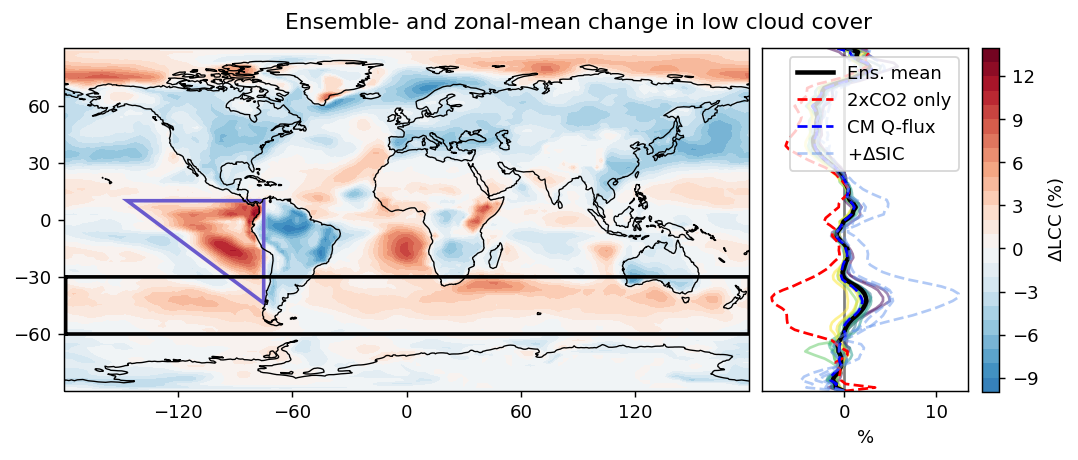

In [23]:
cyclic_dlcc_mean = add_cyclic_point(dlcc.mean(dim='model'), dim='lon', period=360)

fig = plt.figure(figsize=(9, 4), dpi=130)
ax_mean = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
mean_plot = ax_mean.contourf(cyclic_dlcc_mean.lon, cyclic_dlcc_mean.lat, cyclic_dlcc_mean, cmap='RdBu_r', levels=np.arange(-10, 15), norm=colors.CenteredNorm())
ax_mean.add_patch(mpatches.Polygon(xy=[[213.333, 10], [285, 10], [285, -43.75]], facecolor='none', edgecolor='slateblue', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax_mean.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax_mean.coastlines(linewidth=0.75)
ax_mean.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax_mean.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
plt.colorbar(mean_plot, orientation='vertical', label='$\Delta$LCC (%)', shrink=0.78, pad=0.013)

divider = make_axes_locatable(ax_mean)
ax3 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax3)
ax3.set_yticks([])
    
ax3.plot(0*cyclic_dlcc_mean.lat, cyclic_dlcc_mean.lat, color='gray', linestyle='-')

for j, m in enumerate(dlcc.model):
    ax3.plot((dlcc).sel(model=m).mean(dim='lon'), dlcc.lat, color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max())[j]), alpha=0.5)

mz_plot = ax3.plot(cyclic_dlcc_mean.mean(dim='lon'), cyclic_dlcc_mean.lat, 'k', linewidth=2.5, label='Ens. mean')
mzco2_plot = ax3.plot(co2_lcc.mean(dim='lon'), co2_lcc.lat, 'r', linestyle='--', label='2xCO2 only')
mzem_plot = ax3.plot(em_lcc.mean(dim='lon'), em_lcc.lat, 'b', linestyle='--', label='CM Q-flux')

for j, m in enumerate(cold_lcc.model):
    if j == 0:
        ax3.plot((cold_lcc).sel(model=m).mean(dim='lon'), dlcc.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif j != 0:
        ax3.plot((cold_lcc).sel(model=m).mean(dim='lon'), dlcc.lat, color='cornflowerblue', linestyle='--', alpha=0.5)

ax3.set_ylim(-90, 90)
ax3.set_xlabel('%')
plt.legend(loc='upper right')

plt.suptitle('Ensemble- and zonal-mean change in low cloud cover', y=0.86)
plt.tight_layout()

## Figure 8: LCC patch correlation

Calculate regional-average LCC changes:

In [24]:
eptri_lcc = global_average(dlcc.where(((dlcc.lat + 0.75*dlcc.lon) > 170) & (dlcc.lat < 10) & (dlcc.lon < 285)))
smid_lcc = global_average(dlcc.where((dlcc.lat < -30) & (dlcc.lat > -60)))

eptri_cold_lcc = global_average(cold_lcc.where(((cold_lcc.lat + 0.75*cold_lcc.lon) > 170) & (cold_lcc.lat < 10) & (cold_lcc.lon < 285)))
smid_cold_lcc = global_average(cold_lcc.where((cold_lcc.lat < -30) & (cold_lcc.lat > -60)))

eptri_em_lcc = global_average(em_lcc.where(((em_lcc.lat + 0.75*em_lcc.lon) > 170) & (em_lcc.lat < 10) & (em_lcc.lon < 285)))
smid_em_lcc = global_average(em_lcc.where((em_lcc.lat < -30) & (em_lcc.lat > -60)))

eptri_co2_lcc = global_average(co2_lcc.where(((co2_lcc.lat + 0.75*co2_lcc.lon) > 170) & (co2_lcc.lat < 10) & (co2_lcc.lon < 285)))
smid_co2_lcc = global_average(co2_lcc.where((co2_lcc.lat < -30) & (co2_lcc.lat > -60)))

In [25]:
ecs = global_average(ecs_map)
cold_tcr = global_average(cold_tcr_map)

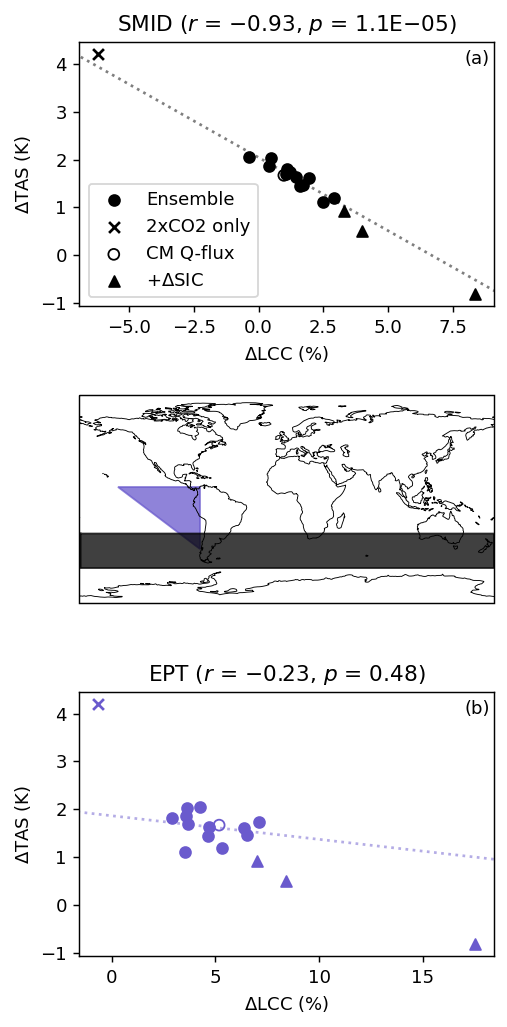

In [26]:
fig2 = plt.figure(figsize=(4, 8), dpi=130)

x = np.linspace(-10, 20, 20)

z1 = np.polyfit(smid_lcc, tcr, 1)
m1, b1 = z1[0], z1[1]

ax1 = plt.subplot(3, 1, 1)
ax1.scatter(smid_lcc, tcr, color='k', label='Ensemble')
ax1.scatter(smid_co2_lcc, ecs, color='k', marker='x', label='2xCO2 only')
ax1.scatter(smid_em_lcc, em_tcr, color='k', facecolors='none', label='CM Q-flux')
ax1.scatter(smid_cold_lcc, cold_tcr, color='k', marker='^', label='+$\Delta$SIC')
ax1.set_ylabel('$\Delta$TAS (K)')
ax1.set_xlabel('$\Delta$LCC (%)')
ax1.set_title(('SMID ($r$ = %.2f, $p$ = %.1E)' %(pearsonr(smid_lcc, gmst)[0], pearsonr(smid_lcc, gmst)[1])).replace("-", u"\u2212"))
xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
ax1.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend(loc='lower left')

z3 = np.polyfit(eptri_lcc, tcr, 1)
m3, b3 = z3[0], z3[1]

ax3 = plt.subplot(3, 1, 3)
ax3.scatter(eptri_lcc, tcr, color='slateblue')
ax3.scatter(eptri_cold_lcc, cold_tcr, color='slateblue', marker='^')
ax3.scatter(eptri_em_lcc, em_tcr, color='slateblue', facecolors='none')
ax3.scatter(eptri_co2_lcc, ecs, color='slateblue', marker='x')
ax3.set_ylabel('$\Delta$TAS (K)')
ax3.set_xlabel('$\Delta$LCC (%)')
ax3.set_title(('EPT ($r$ = %.2f, $p$ = %.2f)' %(pearsonr(eptri_lcc, gmst)[0], pearsonr(eptri_lcc, gmst)[1])).replace("-", u"\u2212"))
xlim3, ylim3 = ax3.get_xlim(), ax3.get_ylim()
ax3.plot(x, m3*x+b3, color='slateblue', linestyle=':', alpha=0.5)
ax3.set_xlim(xlim3)
ax3.set_ylim(ylim3)

ax2 = plt.subplot(3, 1, 2, projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([0, 359, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
ax2.add_patch(mpatches.Polygon(xy=[[213.333, 10], [285, 10], [285, -43.75]], facecolor='slateblue', edgecolor='slateblue', alpha=0.75, transform=ccrs.PlateCarree()))
ax2.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='k', edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree()))
ax2.coastlines(linewidth=0.5)

ax1.text(.99, .97, '(a)', ha='right', va='top', transform=ax1.transAxes)
ax3.text(.99, .97, '(b)', ha='right', va='top', transform=ax3.transAxes)

plt.tight_layout()

## Figure 9: Cloud-controlling factors

Calculate change in cloud-controlling factors:

In [27]:
w500_tcr = response.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')
w500_em = resp_em.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')
w500_co2 = resp_co2.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')
w500_cold = resp_cold.OMEGA.sel(lev=500, method='nearest') - ctrl.OMEGA.sel(lev=500, method='nearest')

u10_tcr = response.U10 - ctrl.U10
u10_em = resp_em.U10 - ctrl.U10
u10_co2 = resp_co2.U10 - ctrl.U10
u10_cold = resp_cold.U10 - ctrl.U10

ts_tcr = response.TS - ctrl.TS
ts_em = resp_em.TS - ctrl.TS
ts_co2 = resp_co2.TS - ctrl.TS
ts_cold = resp_cold.TS - ctrl.TS

eis_response = EIS(response.TS, response.T.sel(lev=700, method='nearest'))
eis_em_resp = EIS(resp_em.TS, resp_em.T.sel(lev=700, method='nearest'))
eis_co2_resp = EIS(resp_co2.TS, resp_co2.T.sel(lev=700, method='nearest'))
eis_ctrl = EIS(ctrl.TS, ctrl.T.sel(lev=700, method='nearest'))
eis_cold_resp = EIS(resp_cold.TS, resp_cold.T.sel(lev=700, method='nearest'))

eis_tcr = eis_response - eis_ctrl
eis_em = eis_em_resp - eis_ctrl
eis_co2 = eis_co2_resp - eis_ctrl
eis_cold = eis_cold_resp - eis_ctrl

Functions to calculate Southern Hemisphere midlatitude average and plot trend lines:

In [28]:
def smid(da):
    return global_average(da.where((da.lat > -60) & (da.lat < -30)))

def plot_trend(ax, x, y):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xrange = np.arange(-10, 10, 1)
    z = np.polyfit(x, y, 1)
    m, b = z[0], z[1]
    ax.plot(xrange, m*xrange+b, color='k', linestyle=':', alpha=0.5)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

The plot:

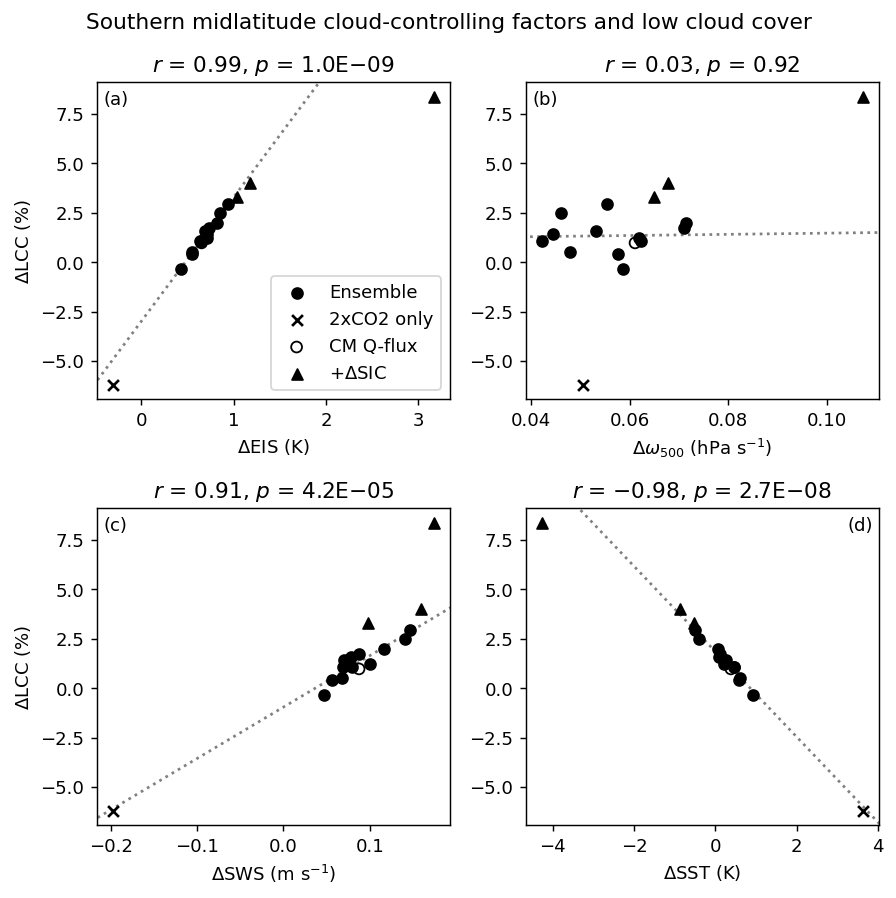

In [29]:
fig = plt.figure(figsize=(7, 7), dpi=130)

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(smid(eis_tcr), smid(dlcc), color='k', label='Ensemble')
ax1.scatter(smid(eis_co2), smid(co2_lcc), color='k', marker='x', label='2xCO2 only')
ax1.scatter(smid(eis_em), smid(em_lcc), color='k', facecolors='none', label='CM Q-flux')
ax1.scatter(smid(eis_cold), smid(cold_lcc), color='k', marker='^', label='+$\Delta$SIC')
plot_trend(ax1, smid(eis_tcr), smid_lcc)
ax1.set_title(('$r$ = %.2f, $p$ = %.1E' %(pearsonr(smid(eis_tcr), smid_lcc)[0], pearsonr(smid(eis_tcr), smid_lcc)[1])).replace("-", u"\u2212"))
plt.legend()

ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(smid(w500_tcr)*100, smid(dlcc), color='k')
ax2.scatter(smid(w500_em)*100, smid(em_lcc), color='k', facecolors='none')
ax2.scatter(smid(w500_co2)*100, smid(co2_lcc), color='k', marker='x')
ax2.scatter(smid(w500_cold)*100, smid(cold_lcc), color='k', marker='^')
plot_trend(ax2, smid(w500_tcr)*100, smid_lcc)
ax2.set_title(('$r$ = %.2f, $p$ = %.2f' %(pearsonr(smid(w500_tcr), smid_lcc)[0], pearsonr(smid(w500_tcr), smid_lcc)[1])).replace("-", u"\u2212"))

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(smid(u10_tcr), smid(dlcc), color='k')
ax3.scatter(smid(u10_em), smid(em_lcc), color='k', facecolors='none')
ax3.scatter(smid(u10_co2), smid(co2_lcc), color='k', marker='x')
ax3.scatter(smid(u10_cold), smid(cold_lcc), color='k', marker='^')
plot_trend(ax3, smid(u10_tcr), smid_lcc)
ax3.set_title(('$r$ = %.2f, $p$ = %.1E' %(pearsonr(smid(u10_tcr), smid_lcc)[0], pearsonr(smid(u10_tcr), smid_lcc)[1])).replace("-", u"\u2212"))

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(smid(ts_tcr), smid(dlcc), color='k')
ax4.scatter(smid(ts_em), smid(em_lcc), color='k', facecolors='none')
ax4.scatter(smid(ts_co2), smid(co2_lcc), color='k', marker='x')
ax4.scatter(smid(ts_cold), smid(cold_lcc), color='k', marker='^')
plot_trend(ax4, smid(ts_tcr), smid_lcc)
ax4.set_title(('$r$ = %.2f, $p$ = %.1E' %(pearsonr(smid(ts_tcr), smid_lcc)[0], pearsonr(smid(ts_tcr), smid_lcc)[1])).replace("-", u"\u2212"))

ax1.set_ylabel('$\Delta$LCC (%)')
ax3.set_ylabel('$\Delta$LCC (%)')
ax1.set_xlabel('$\Delta$EIS (K)')
ax2.set_xlabel('$\Delta\omega_{500}$ (hPa s$^{-1}$)')
ax3.set_xlabel('$\Delta$SWS (m s$^{-1}$)')
ax4.set_xlabel('$\Delta$SST (K)')

ax1.text(.02, .975, '(a)', ha='left', va='top', transform=ax1.transAxes)
ax2.text(.02, .975, '(b)', ha='left', va='top', transform=ax2.transAxes)
ax3.text(.02, .975, '(c)', ha='left', va='top', transform=ax3.transAxes)
ax4.text(.985, .975, '(d)', ha='right', va='top', transform=ax4.transAxes)

fig.suptitle('Southern midlatitude cloud-controlling factors and low cloud cover')
plt.tight_layout()

## Figure 10: Eddy kinetic energy

Calculate total kinetic energy (`tke`) and subtract out time-averaged kinetic energy to get eddy kinetic energy (`eke`):

In [30]:
tke = 0.5*(response.UU + response.VV)
tke_cold = 0.5*(resp_cold.UU + resp_cold.VV)
tke_ctrl = 0.5*(ctrl.UU + ctrl.VV)
tke_co2 = 0.5*(resp_co2.UU + resp_co2.VV)
tke_em = 0.5*(resp_em.UU + resp_em.VV)

eke = tke - 0.5*(response.U**2 + response.V**2)
eke_cold = tke_cold - 0.5*(resp_cold.U**2 + resp_cold.V**2)
eke_ctrl = tke_ctrl - 0.5*(ctrl.U**2 + ctrl.V**2)
eke_co2 = tke_co2 - 0.5*(resp_co2.U**2 + resp_co2.V**2)
eke_em = tke_em - 0.5*(resp_em.U**2 + resp_em.V**2)

Integrate (sum) EKE between two specified pressures:

In [31]:
max_lev = 250
min_lev = 850

int_eke = eke.where((eke.lev > max_lev) & (eke.lev < min_lev)).sum(dim='lev')
int_eke_cold = eke_cold.where((eke_cold.lev > max_lev) & (eke_cold.lev < min_lev)).sum(dim='lev')
int_eke_ctrl = eke_ctrl.where((eke_ctrl.lev > max_lev) & (eke_ctrl.lev < min_lev)).sum(dim='lev')
int_eke_co2 = eke_co2.where((eke_co2.lev > max_lev) & (eke_co2.lev < min_lev)).sum(dim='lev')
int_eke_em = eke_em.where((eke_em.lev > max_lev) & (eke_em.lev < min_lev)).sum(dim='lev')

Function for NH midlatitude averages:

In [32]:
def nmid(da):
    return global_average(da.where((da.lat > 30) & (da.lat < 60)))

Calculate NH midlatitude LCC changes:

In [33]:
nmid_lcc = nmid(dlcc)
nmid_cold_lcc = nmid(cold_lcc)
nmid_em_lcc = nmid(em_lcc)
nmid_co2_lcc = nmid(co2_lcc)

Calculate changes in EKE:

In [34]:
eke_diff = int_eke - int_eke_ctrl
cold_eke_diff = int_eke_cold - int_eke_ctrl
em_eke_diff = int_eke_em - int_eke_ctrl
co2_eke_diff = int_eke_co2 - int_eke_ctrl

Midlatitude averages:

In [35]:
smid_eke_diff = smid(eke_diff)
nmid_eke_diff = nmid(eke_diff)

cold_smid_eke_diff = smid(cold_eke_diff)
cold_nmid_eke_diff = nmid(cold_eke_diff)

em_smid_eke_diff = smid(em_eke_diff)
em_nmid_eke_diff = nmid(em_eke_diff)

co2_smid_eke_diff = smid(co2_eke_diff)
co2_nmid_eke_diff = nmid(co2_eke_diff)

The plot:

(-6.914366435261131, 9.090351822691895)

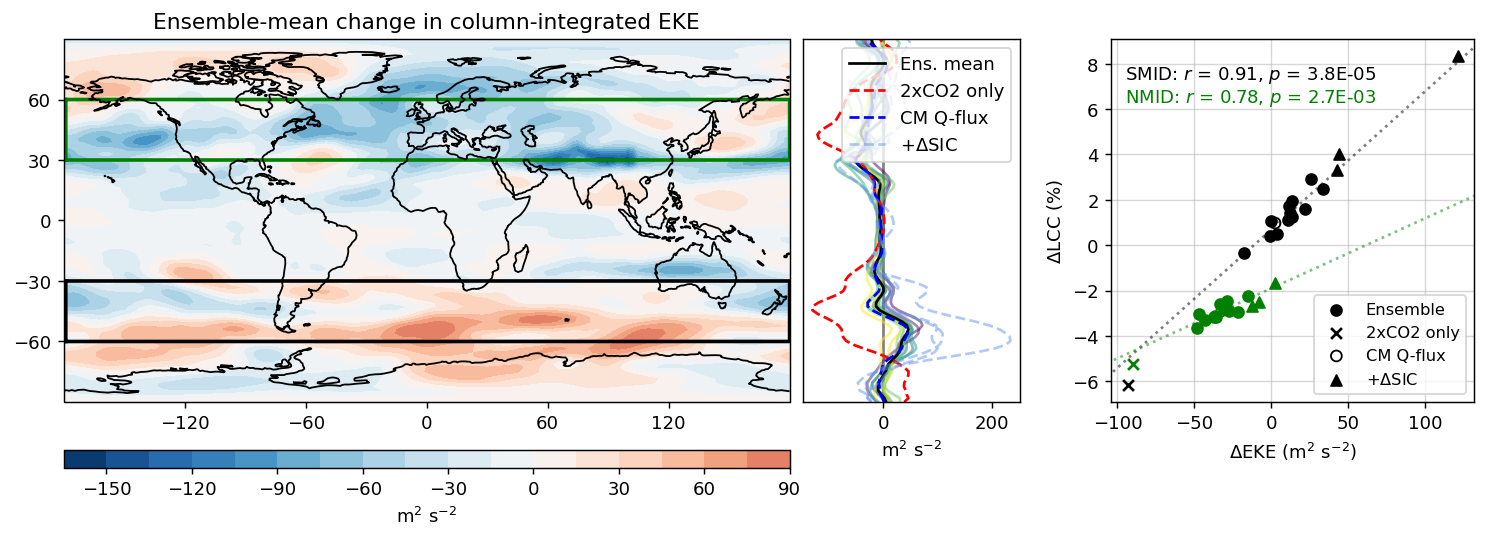

In [36]:
fig = plt.figure(figsize=(14, 3), dpi=130)

cyclic_eke_diff = add_cyclic_point(eke_diff, dim='lon', period=360)

ax_mean = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
mean_plot = ax_mean.contourf(cyclic_eke_diff.lon, cyclic_eke_diff.lat, cyclic_eke_diff.mean(dim='model'), cmap='RdBu_r', levels=21, norm=colors.CenteredNorm())
ax_mean.coastlines()
ax_mean.add_patch(mpatches.Rectangle(xy=[-180, 30], width=361, height=30, facecolor='none', edgecolor='g', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax_mean.add_patch(mpatches.Rectangle(xy=[-180, -60], width=361, height=30, facecolor='none', edgecolor='k', linewidth=2, alpha=1, transform=ccrs.PlateCarree()))
ax_mean.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax_mean.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
ax_mean.set_title('Ensemble-mean change in column-integrated EKE')

divider = make_axes_locatable(ax_mean)
ax_cb = divider.new_vertical(size="5%", pad=-3.3, axes_class=plt.Axes)
plt.colorbar(mean_plot, cax=ax_cb, orientation='horizontal', label='m$^2$ s$^{-2}$')
fig.add_axes(ax_cb)

x = np.linspace(-200, 200, 10)
z1 = np.polyfit(smid_eke_diff, smid_lcc, 1)
z2 = np.polyfit(nmid_eke_diff, nmid_lcc, 1)

m1, b1 = z1[0], z1[1]
m2, b2 = z2[0], z2[1]

ax_z = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_z)
ax_z.set_yticks([])

ax_z.vlines(0, -90, 90, color='gray')
for j, m in enumerate(int_eke.model):
    ax_z.plot((int_eke - int_eke_ctrl).sel(model=m).mean(dim='lon'), int_eke.lat, color=plt.cm.viridis(((tcr-tcr.min())/(tcr-tcr.min()).max())[j]), alpha=0.5)

    
ax_z.plot(eke_diff.mean(dim=['lon', 'model']), int_eke.lat, 'k', linestyle='-', label='Ens. mean')
ax_z.plot(co2_eke_diff.mean(dim='lon'), int_eke_co2.lat, 'r', linestyle='--', label='2xCO2 only')
ax_z.plot(em_eke_diff.mean(dim='lon'), int_eke_em.lat, 'b', linestyle='--', label='CM Q-flux')

for j, m in enumerate(int_eke_cold.model):
    if j == 0:
        ax_z.plot(cold_eke_diff.sel(model=m).mean(dim='lon'), int_eke_cold.lat, color='cornflowerblue', linestyle='--', alpha=0.5, label='+$\Delta$SIC')
    elif j != 0:
        ax_z.plot(cold_eke_diff.sel(model=m).mean(dim='lon'), int_eke_cold.lat, color='cornflowerblue', linestyle='--', alpha=0.5)
        
ax_z.set_ylim(-90, 90)
ax_z.set_xlabel('m$^2$ s$^{-2}$')
plt.legend()

ax_sc = divider.new_horizontal(size="50%", pad=0.7, axes_class=plt.Axes)
fig.add_axes(ax_sc)
ax_sc.scatter(smid_eke_diff, smid_lcc, color='k', marker='o', label='Ensemble')
ax_sc.scatter(nmid_eke_diff, nmid_lcc, color='g', marker='o')
ax_sc.scatter(co2_smid_eke_diff, smid_co2_lcc, color='k', marker='x', label='2xCO2 only')
ax_sc.scatter(co2_nmid_eke_diff, nmid_co2_lcc, color='g', marker='x')
ax_sc.scatter(em_smid_eke_diff, smid_em_lcc, edgecolor='k', facecolor='none', label='CM Q-flux')
ax_sc.scatter(em_nmid_eke_diff, nmid_em_lcc, edgecolor='g', facecolor='none')
ax_sc.scatter(cold_smid_eke_diff, smid_cold_lcc, color='k', marker='^', label='+$\Delta$SIC')
ax_sc.scatter(cold_nmid_eke_diff, nmid_cold_lcc, color='g', marker='^')

plt.legend(loc='lower right', prop = {'size': 9})

xlim = ax_sc.get_xlim()
ylim = ax_sc.get_ylim()

ax_sc.plot(x, m1*x+b1, color='k', linestyle=':', alpha=0.5)
ax_sc.plot(x, m2*x+b2, color='g', linestyle=':', alpha=0.5)

ax_sc.set_xlabel('$\Delta$EKE (m$^2$ s$^{-2}$)')
ax_sc.set_ylabel('$\Delta$LCC (%)')

smid_pcc, smid_p = pearsonr(smid_eke_diff, smid_lcc)[0:2]
nmid_pcc, nmid_p = pearsonr(nmid_eke_diff, nmid_lcc)[0:2]
ax_sc.text(x=-95, y=7.3, s='SMID: $r$ = %.2f, $p$ = %.1E' %(smid_pcc, smid_p), color='k')
ax_sc.text(x=-95, y=6.3, s='NMID: $r$ = %.2f, $p$ = %.1E' %(nmid_pcc, nmid_p), color='g')

ax_sc.set_axisbelow(True)
plt.grid(alpha=0.5)
ax_sc.set_xlim(xlim)
ax_sc.set_ylim(ylim)